<a href="https://colab.research.google.com/github/prunprun/DLproject/blob/master/tutorial7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 7 - Auto Encoder

In this tutorial, you will code a denoising autoencoder and familiarize yourself with the latent space concept.

Mount your drive:

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')
test

Mounted at /content/gdrive/


In [2]:
import sys
sys.path.append('/content/gdrive/My Drive/DL_tutorials/tutorial7')

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import numpy as np
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

In [4]:
from layers import Encoder, Decoder
from net import AutoEncoderNet
from solver import Solver
from datasets import MNISTNoisedDataset, CelebADataset
from vis_utils import *
from utils import *
%load_ext autoreload
%autoreload 2

Enable Cuda if gpu  available.

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print ("Using device {}".format(device))

Using device cuda:0


#### Setup Datasets and Dataloader

In [6]:
mnist_train = torchvision.datasets.MNIST('/content/gdrive/My Drive/DL_tutorials/tutorial7/data', train=True, download=True, \
                          transform=torchvision.transforms.ToTensor())

mnist_test = torchvision.datasets.MNIST('/content/gdrive/My Drive/DL_tutorials/tutorial7/data', train=False, download=True,\
                                        transform=torchvision.transforms.ToTensor())

batch_size = 256 

train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size)

### Encoder
**Todo:** Implement the Encoder as a fully-connected, two layer neural network with output dimensions equal to embedded_dim: Complete the missing parts in class `Encoder` in file `layers.py`. <br>
Do you need a non-linearity after the last layer?

In [11]:
# Encoder
input_size = 28 * 28
embedded_dim = 32
hidden_dim = 100

# sample a random example
x = torch.randn(1, input_size)

# setup encoder
encoder = Encoder(input_size, embedded_dim, hidden_dim=hidden_dim)

# encode
encoded_x = encoder(x)

assert (encoded_x.shape[-1] == embedded_dim)
# print shapes
print ('Orignal Shape:{}'.format(x.shape))
print ('Encoded Shape:{}'.format(encoded_x.shape))

Orignal Shape:torch.Size([1, 784])
Encoded Shape:torch.Size([1, 32])


### Decoder
Implement the decoder as a fully-connected, two layer neural network with input dimensions equal to embedded_dim. Complete the missing parts in class `Decoder` in file `layers.py`. <br>
Do you need a non-linearity after the last layer?

In [ ]:
# decoder
decoder = Decoder(embedded_dim, input_size, hidden_dim=hidden_dim)
decoded_x = decoder(encoded_x)

assert (decoded_x.shape[-1] == x.shape[-1])

# print shapes
print ('Encoded Shape:{}'.format(encoded_x.shape))
print ('Decoded Shape:{}'.format(decoded_x.shape))

Encoded Shape:torch.Size([1, 32])
Decoded Shape:torch.Size([1, 784])


### AutoEncoder Network
Implement a **AutoEncoder** by completing the missing parts in class `AutoEncoderNet` in `net.py`. Use the `Encoder` and `Decoder` classes you implemented before.

In [ ]:
inputs = x
reconstructed_x = None

# Todo - encode and decode the sample input using the implemented Autoencoder ##
#input_size = x.shape[-1]
autoencoder = AutoEncoderNet(input_size, embedded_dim)
reconstructed_x = autoencoder(x)
################################################################################

assert (reconstructed_x.shape == x.shape)

The process of encoding followed by decoding and minimizing the reconstruction loss trains network to find the 
embedding that minimize the reconstruction error.
Reconstruction losses

#### Loss function
You can use different loss functions for this task. The following loss
functions are mist common:
- Mean Squared Error
    - Minimize L2 distance between two images.
    
- Binary Cross-Entropy
    - The Decoder predicts pixel values in the range [0,1]. We can interpret these values as pixel probabilities and apply the Cross-Entropy Loss on these probabilities. (Recall the Categorical Cross-Entropy for multi-class prediction. Binary Cross-Entropy is a special case if we only have 2 classes. In this case, a single output probability is sufficient, as the probability of the other class is (1-p). We can therefore apply a pixel-wise Binary Cross-Entropy on the output of the decoder.)
    
In this tutorial, we choose a Binary Cross-Entropy loss.

In [ ]:
loss_func = nn.BCELoss()

#### Setup optimizer, solver and train
**Todo:** Finish the missing parts of `Solver.train()` in `solver.py`

In [ ]:
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)
solver = Solver(optimizer, loss_func, device=device)
solver.train(autoencoder, train_loader, num_epochs=10, use_data_as_labels=True)


[Epoch 1/10] TRAIN loss: 0.270

[Epoch 2/10] TRAIN loss: 0.172

[Epoch 3/10] TRAIN loss: 0.148

[Epoch 4/10] TRAIN loss: 0.133

[Epoch 5/10] TRAIN loss: 0.123

[Epoch 6/10] TRAIN loss: 0.115

[Epoch 7/10] TRAIN loss: 0.109

[Epoch 8/10] TRAIN loss: 0.105

[Epoch 9/10] TRAIN loss: 0.103

[Epoch 10/10] TRAIN loss: 0.100


In [ ]:
a = x.squeeze()
a.shape

torch.Size([784])

#### Encode/Decode a batch of test samples

In [ ]:
# sample a batch and move it to gpu if available
sample_test_batch, sample_test_labels=next(iter(test_loader))
sample_test_batch = sample_test_batch.to(device)

# encode-> decode the images
reconstructed_samples = autoencoder(sample_test_batch.flatten(1))

#### Visualize Results
Note: Visualization utility helper methods are defined in `visutils.py`, in case you wanted to have a look.

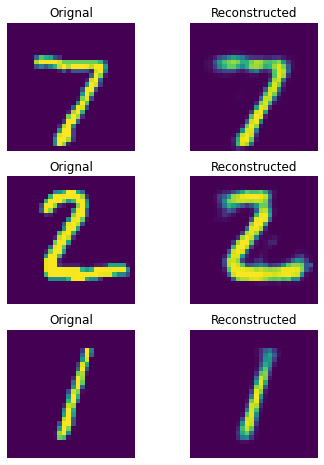

In [ ]:
visulize_reconstructed(sample_test_batch.cpu().numpy(), reconstructed_samples.detach().cpu().numpy())

We have managed to encode the 784 dimensional vector into a just  32 dimensional vector. We are able to reconstructed the original vector again using the decoder, without significant information loss as
visible in the plot above.

How does the Autoencoder compare to PCA?

Your answer here!

## Analyze the latent space
Even though we've compressed the 784-dimensional inputs into a 32-dimensional vector, visualizing 32 dimensional numbers is still difficult! We therefore compute the 't-distributed Stochastic Neighbor Embedding' (t-SNE) to map the 32 dimensions onto 2 dimensions for visualization. Note that t-SNE projects data points such that 2 close points in the 32-dimensional space will also be close in the 2-dimensional space.

Here's the documentation of the scikit-learn implementation:
https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

In [ ]:
# sample a batch from the test loader and move to gpu if available
#sample_test_batch, sample_test_labels=next(iter(test_loader))
#sample_test_batch = sample_test_batch.to(device)

embeddings = None
## todo - encode the sampled batch and print its dimensions ##

embeddings = encoder(sample_test_batch.flatten(1))
print(embeddings.shape)
###############################################################

# Use Sklearn TSNE  implementation
# Create a tsne for projecting the high dimensional to 2D for visualization
tsne = TSNE(n_components=2)
embeddings = embeddings.detach().cpu().numpy()

# apply projection
latent_projections = tsne.fit_transform(embeddings)

torch.Size([256, 32])


In [ ]:
sample_test_batch.shape

### Visualize Embeddings in 2D projected space

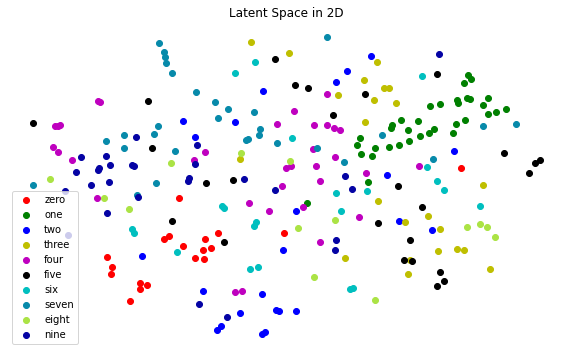

In [ ]:
# initialize a matplotlib plot
fig = plt.figure()
ax = fig.add_subplot(111)

tx = latent_projections[:,0]
ty = latent_projections[:,1]

labels = sample_test_labels.numpy()
named_labels=['zero','one','two','three','four','five','six','seven','eight','nine']
colors = ['r','g','b','y','m', 'k','c','#078aaa', '#abe345','#0503a4']

# for every class, we'll add a scatter plot separately
for idx, label in enumerate(named_labels):
    # find the samples of the current class in the data
    indices = [i for i, l in enumerate(labels) if l == idx]

    # extract the coordinates of the points of this class only
    current_tx = np.take(tx, indices)
    current_ty = np.take(ty, indices)

    # add a scatter plot with the corresponding color and label
    ax.scatter(current_tx, current_ty, c=colors[idx], label=label)
    ax.axis('off')

ax.legend(loc='best')
plt.gcf().set_size_inches(10, 6)
plt.title('Latent Space in 2D')
plt.show()

* You can see clear clusters in the latent space to simplify the decoding later on.
* Which numbers are close together? Your analysis?

Your answer here!

## MNIST denoising auto encoder
Now we want to use our autoencoder to improve data quality and reduce measurement noise.

#### Setup Noised Dataset
**Todo:** Update the `__getitem__()` method in `class MNISTNoisedDataset` in `datasets.py` to return a noisy image as input and the original noise-free image as label.

In [7]:
mnist_noised_train = MNISTNoisedDataset('/content/gdrive/My Drive/DL_tutorials/tutorial7/data', train=True, download=True, noise_factor=0.4)

mnist_noised_test = MNISTNoisedDataset('/content/gdrive/My Drive/DL_tutorials/tutorial7/data', train=False, download=True, noise_factor=0.4)

batch_size = 256 

train_noised_loader = torch.utils.data.DataLoader(mnist_noised_train, batch_size=batch_size)
test_noised_loader = torch.utils.data.DataLoader(mnist_noised_test, batch_size=batch_size)

#### Visualize the noisy and orignal images from the test set

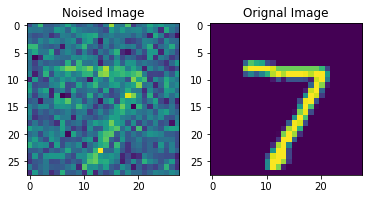

In [8]:
noised_sample, orignal_sample = next(iter(test_noised_loader))
plt.subplot(1,2,1)
plt.title('Noised Image')
plt.imshow(noised_sample[0].numpy().squeeze())

plt.subplot(1,2,2)
plt.title('Orignal Image')
plt.imshow(orignal_sample[0].numpy().squeeze())

#### Setup solver, optimizer and train
Note: Make sure the `class Solver` in `solver.py` differentiates reconstruction and de-noising depending on the value of `use_data_as_labels`.

In [12]:
denoising_autoencoder = AutoEncoderNet(input_size, embedded_dim)

# train
denoising_optimizer = torch.optim.Adam(denoising_autoencoder.parameters(), lr=1e-3)
denoising_solver = Solver(denoising_optimizer, loss_func=nn.BCELoss(), device=device)
denoising_solver.train(denoising_autoencoder, train_noised_loader, num_epochs=10, use_data_as_labels=False)


[Epoch 1/10] TRAIN loss: 0.269

[Epoch 2/10] TRAIN loss: 0.175

[Epoch 3/10] TRAIN loss: 0.153

[Epoch 4/10] TRAIN loss: 0.139

[Epoch 5/10] TRAIN loss: 0.131

[Epoch 6/10] TRAIN loss: 0.126

[Epoch 7/10] TRAIN loss: 0.122

[Epoch 8/10] TRAIN loss: 0.119

[Epoch 9/10] TRAIN loss: 0.117

[Epoch 10/10] TRAIN loss: 0.116


#### Visualize Denoising

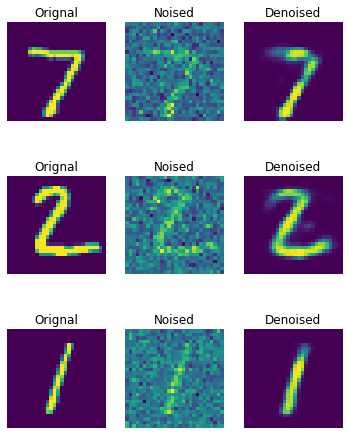

In [13]:
# sample a batch and move to gpu
sample_test_batch, sample_test_labels = next(iter(test_noised_loader))
sample_test_batch = sample_test_batch.to(device)

# perform forward pass
reconstructed_samples = denoising_autoencoder(sample_test_batch.flatten(1))

# convert denoised tensors back to numpy based image arrays
visulize_noised_reconstructed(sample_test_labels.numpy(), sample_test_batch.cpu().numpy(), \
                              reconstructed_samples.detach().cpu().numpy())

Even though the noise in the data is rather large, the de-noising works surprisingly well!

### CelebA Dataset
This dataset consists of larger colored images of celebrities from diverse sources providing a rich set of features for ML algorithms to learn complex hidden underlying structural relationships in high-dimensional images. 

**Todo:** Setup the data, train the autoencoder and analyze the learned representations.

In [14]:
batch_size = 256

# todo - use different image sizes
img_size = 32

# transformation to downsample image and convert to Tensor
transforms = torchvision.transforms.Compose(
                [torchvision.transforms.Resize(img_size),
                 torchvision.transforms.ToTensor()])

# Train and test datasets
celeb_train_ds = CelebADataset("./data", download=True, transform=transforms)
celeb_test_ds = CelebADataset("./data", download=True, split='test', transform=transforms)

# train and test data loaders
celeb_train_loader = torch.utils.data.DataLoader(celeb_train_ds, shuffle=True, batch_size=batch_size)
celeb_test_loader = torch.utils.data.DataLoader(celeb_test_ds, shuffle=True, batch_size=batch_size)


Files already downloaded and verified


#### Visualize sample Images from Dataset

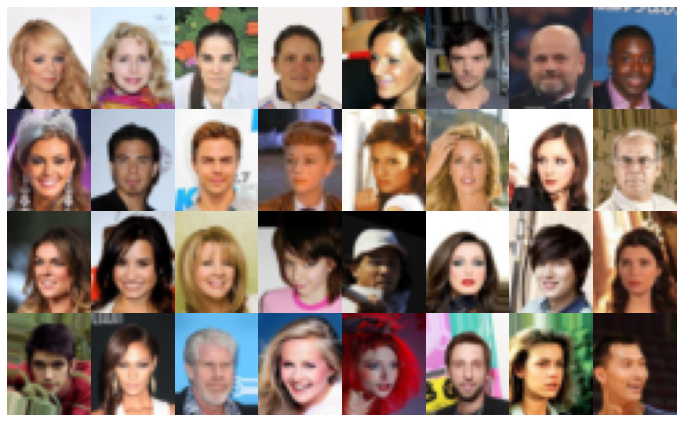

In [15]:
# sample a batch
batch_data, attrs = next(iter(celeb_train_loader))
batch_data_numpy = tensor_to_numpy_images(batch_data)

# visualize
visulize_samples(batch_data_numpy)

### Setup and train AutoEncoder

In [16]:
# get the dimensions of the samples
_, width, height, channels = batch_data_numpy.shape

# Adjust dimension of input vector
input_size = width * height * channels

# optional - Try different compressed dimensions 
embedded_dim = 128

celeb_autoencoder = AutoEncoderNet(input_size=input_size, embedded_dim=embedded_dim)

# train
celeb_optimizer = torch.optim.Adam(celeb_autoencoder.parameters(), lr=1e-3)
celeb_solver=Solver(celeb_optimizer, loss_func=nn.BCELoss(), device=device)
celeb_solver.train(celeb_autoencoder, celeb_train_loader, num_epochs=5, use_data_as_labels=True)


[Epoch 1/5] TRAIN loss: 0.559

[Epoch 2/5] TRAIN loss: 0.534

[Epoch 3/5] TRAIN loss: 0.530

[Epoch 4/5] TRAIN loss: 0.528

[Epoch 5/5] TRAIN loss: 0.528


#### Visulize the decoded images

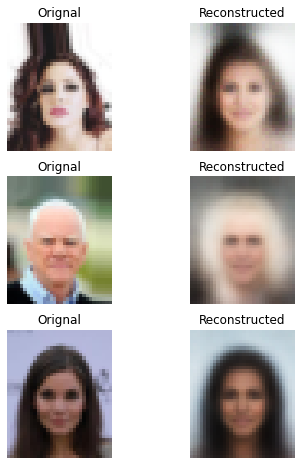

In [17]:
# sample a random batch and move to gpu
sample_test_batch, sample_test_labels = next(iter(celeb_test_loader))
sample_test_batch = sample_test_batch.to(device)

# run forward pass - input -> encoder-> decoder -> decoded image
reconstructed_samples = celeb_autoencoder(sample_test_batch.flatten(1))

# move back to cpu for image visualization.
reconstructed_samples = reconstructed_samples.cpu() 
sample_test_batch = sample_test_batch.cpu()

# convert denoised tensors back to numpy based image arrays
reconstructed_samples = tensor_to_numpy_images(reconstructed_samples.reshape(sample_test_batch.shape))
sample_test_batch = tensor_to_numpy_images(sample_test_batch)

# plot results
visulize_reconstructed(sample_test_batch, reconstructed_samples, img_size=(width,height, channels))

### Analyze the latent space 
Analogous to above, we sample a batch from the test set and calculate embeddings using the encoder. The embeddings are projected to 2D using t-SNE as we can't directly visulize higher-dimensional latent spaces.

In [ ]:
# sample a batch from the test loader and move to gpu if available
sample_test_batch, sample_test_labels = next(iter(celeb_test_loader))
sample_test_batch = sample_test_batch.to(device)

# encode the images
embeddings = celeb_autoencoder.encoder(sample_test_batch.flatten(1))
print ('Encoded Size: {}'.format(embeddings.size()))

# Create a tsne for projecting the high dimensional tensor to 2D for visualization
tsne = TSNE(n_components=2)

# calcualte projections
embeddings = embeddings.detach().cpu().numpy()
latent_projections = tsne.fit_transform(embeddings)

# separate x and y coords for plotting
tx = latent_projections[:,0]
ty = latent_projections[:,1]

tx = normalize(tx)
ty = normalize(ty)

# convert to numpy
sample_test_batch_npy = tensor_to_numpy_images(sample_test_batch.cpu())

#### Show Latent space with images
Each image is drawn at its position in the projected into the latent space. Observe that similar images cluster together without using any labels throughout the training process.

In [ ]:
plot_width = 1000
plot_height = 1000

tsne_plot = np.ones((plot_width + width, plot_height + height, 3), np.float32)
for img, x, y in zip(sample_test_batch_npy, tx, ty):
    
    # calculate the corresponding position in the image
    xpos = int(x * plot_width)
    ypos = int(y * plot_height)
    
    # assign the image as subimage in the larger plot image
    tsne_plot[xpos:xpos + width, ypos:ypos+height,:] = img
    
plt.gcf().set_size_inches(18, 18)
plt.imshow(tsne_plot)

#### Latent space with Encoded-Decoded Images
Analogous to the previous plot. However, this time the images are replaced with their decoded reconstructions. Observe the transitions in the images in the latent space. The clustering now becomes even clearer. Note that both plots become increasingly similar the better the Autoencoder becomes.

In [ ]:
# encode-decode using the sampled batch using trained auto encoder
sample_test_batch_decoded = celeb_autoencoder(sample_test_batch.flatten(1))
sample_test_batch_decoded = sample_test_batch_decoded.cpu()

# convert from flattened tensor output to orignal shape and then to numpy for visulization
sample_test_batch_decoded = tensor_to_numpy_images(sample_test_batch_decoded.reshape(sample_test_batch.shape))

# the large blank image to hold images
tsne_plot = np.ones((plot_width + width, plot_height + height, 3), np.float32)
for img, x, y in zip(sample_test_batch_decoded, tx, ty):
    
    # calculate the corresponding position in the image
    xpos = int(x * plot_width)
    ypos = int(y * plot_height)
    
    # assign the image as subimage in the larger plot image
    tsne_plot[xpos:xpos + width,ypos:ypos + height,:] = img
    
    
plt.gcf().set_size_inches(16, 16)
plt.imshow(tsne_plot)

We can't be super proud of these results yet, the variety of reconstructable images is far from optimal. You've probably also realized that results get worse when using a stronger compression. We can, of course, improve our model by using convolutional layers. Convolutions can generate very expressive features allowing for a stronger compression. <br> Try to improve the results:

**Todo:** Try adding some more layers in the Encoder and Decoder. Can you improve the reconstruction on Celeb?

**Todo:** If you're fast, you can update the encoder with convolutional layers and the decoder with transpose convolution layers. You can use nn.conv2d() for downscaling and nn.UpsamplingNearest2d() for upscaling.

Congrats on coding a denoising autoencoder and compressing faces into latent space! You've finished tutorial 7!